# Lab 02 : Diffusion Model (DDPM) for MNIST Images -- solution


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5242_2025_codes/labs_lecture08/lab04_dm_image'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [2]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import time

#import utils
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings
import os, datetime

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device= torch.device("cuda") # use GPU
else:
    device= torch.device("cpu")
print(device)


2.2.2
NVIDIA RTX A5000
cuda


### MNIST dataset 

In [3]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
print(train_data.size())


torch.Size([60000, 28, 28])


In [4]:
# Global constants
n = train_data.size(1) # num of pixels along one spatial dimension
dz = 128 # latent dimension
dID = 128 # hidden dimension for ID features
bs = 100 # batch size
N = train_data.size(0) # num of training data
print('n,dz,dID,bs,N:',n,dz,dID,bs,N)

d = 64 # hidden dimension for image features
d = 48
dPE = 128 # hidden dimension for time 
beta_1 = 0.0001
beta_T = 0.02
num_t = 150
print('beta_1,beta_T,num_t,d,dPE:',beta_1,beta_T,num_t,d,dPE)


n,dz,dID,bs,N: 28 128 128 100 60000
beta_1,beta_T,num_t,d,dPE: 0.0001 0.02 150 48 128


### DDPM denoiser with UNet architecture
https://arxiv.org/pdf/1505.04597

Diffusion models require an expressive denoiser to predict the noise that is added to the clean image. A standard denoiser for image is UNet.

The task is to implement UNet, which is designed according to the diagram below:
<center>
<img src="pic/unet.png" style="height:500px"/>
</center>
    
Implement UNet with batch normalization, ReLU activation and residual connection.

Hints: You may use PyTorch modules `nn.Conv2d`, `nn.ConvTranspose2d` and `nn.BatchNorm2d`.


In [5]:
# Network design

class first_block(nn.Module): 
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear_time = nn.Linear(d, in_dim)
        self.ln_time = nn.LayerNorm(in_dim)
        self.conv1 = nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1)  # out size = in size
        self.bn1 = nn.BatchNorm2d(out_dim)
        self.conv2 = nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1) # out size = in size
        self.bn2 = nn.BatchNorm2d(out_dim)
        
    def forward(self, h, t):
        # Add time information t to h
        t = torch.relu(self.ln_time(self.linear_time(t))) # [bs, in_dim]
        h = h + t.unsqueeze(2).unsqueeze(3)               # [bs, in_dim, in_n, in_n]
        # First convolution layer
        h = torch.relu(self.bn1(self.conv1(h)))           # [bs, out_dim, in_n, in_n]
        # Second convolution layer
        h = h + torch.relu(self.bn2(self.conv2(h)))       # [bs, out_dim, in_n, in_n]
        return h

class down_sampling_block(nn.Module):
    def __init__(self, in_dim, out_dim, padding):
        super().__init__()
        self.linear_time = nn.Linear(d, in_dim)
        self.ln_time = nn.LayerNorm(in_dim)
        self.down_conv = nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=2, padding=padding) # out size = in size / 2, downsampling with conv 
        self.bn1 = nn.BatchNorm2d(out_dim)
        self.conv2 = nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1) # out size = in size
        self.bn2 = nn.BatchNorm2d(out_dim)
        self.conv3 = nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1) # out size = in size
        self.bn3 = nn.BatchNorm2d(out_dim)
        
    def forward(self, h, t):
        # Add time information t to h
        t = torch.relu(self.ln_time(self.linear_time(t))) # [bs, in_dim]
        h = h + t.unsqueeze(2).unsqueeze(3)               # [bs, in_dim, in_n, in_n]        
        # First convolution layer
        h = torch.relu(self.bn1(self.down_conv(h)))       # [bs, out_dim, in_n/2, in_n/2]
        # Second convolution layer
        h = h + torch.relu(self.bn2(self.conv2(h)))       # [bs, out_dim, in_n/2, in_n/2]
        # Third convolution layer
        h = h + torch.relu(self.bn3(self.conv3(h)))       # [bs, out_dim, in_n/2, in_n/2]
        return h

class up_sampling_block(nn.Module):
    def __init__(self, in_dim, out_dim, output_padding):
        super().__init__()
        self.linear_time = nn.Linear(d, in_dim) 
        self.ln_time = nn.LayerNorm(in_dim)
        self.up_conv = nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=output_padding) # out size = in size * 2, upsampling with conv 
        self.bn1 = nn.BatchNorm2d(out_dim)
        self.conv2 = nn.Conv2d(2*out_dim, out_dim, kernel_size=3, padding=1) # out size = in size
        self.bn2 = nn.BatchNorm2d(out_dim)
        self.conv3 = nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1)   # out size = in size
        self.bn3 = nn.BatchNorm2d(out_dim)
        
    def forward(self, h_level, h_level_minus_one, t):
        # Add time information t to h
        t = torch.relu(self.ln_time(self.linear_time(t)))      # [bs, in_dim=2*out_dim]
        # First convolution layer
        h_level = h_level + t.unsqueeze(2).unsqueeze(3)        # [bs, out_dim, in_n, in_n]
        h_level = torch.relu(self.bn1(self.up_conv(h_level)))  # [bs, out_dim, in_n*2, in_n*2]
        # Concatenate down-sampling and up-sampling
        h = torch.cat( ( h_level, h_level_minus_one ), dim=1 ) # [bs, in_dim=2*out_dim, in_n*2, in_n*2]
        # Second convolution layer
        h = torch.relu(self.bn2(self.conv2(h)))                # [bs, out_dim, in_n*2, in_n*2]
        # Third convolution layer
        h = h + torch.relu(self.bn3(self.conv3(h)))            # [bs, out_dim, in_n*2, in_n*2]           
        return h

# Define UNet architecture
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_t    =        nn.Embedding(num_t,   d)
        self.first_block =         first_block(    1,   d)
        self.downsample1 = down_sampling_block(    d, 2*d, 1)
        self.downsample2 = down_sampling_block(  2*d, 4*d, 1)
        self.downsample3 = down_sampling_block(  4*d, 8*d, 1)
        self.upsample1   =   up_sampling_block(  8*d, 4*d, 0)
        self.upsample2   =   up_sampling_block(  4*d, 2*d, 1)
        self.upsample3   =   up_sampling_block(  2*d,   d, 1)
        self.last_conv   =         nn.Conv2d(      d,   1, kernel_size=1)
    def forward(self, h_t, sample_t):
        h = h_t.unsqueeze(1)                        # [bs, 1, n, n], [100, 1, 28, 28]
        t = self.linear_t(sample_t)                 # [bs, 1], [100, 1]
        h1_down = self.first_block(h, t)            # [bs, d, n, n], [100, 64, 28, 28]
        h2_down = self.downsample1(h1_down, t)      # [bs, 2d, n/2, n/2], [100, 128, 14, 14]     
        h3_down = self.downsample2(h2_down, t)      # [bs, 4d, n/4, n/4], [100, 256, 7, 7]
        h4_down = self.downsample3(h3_down, t)      # [bs, 8d, n/8, n/8], [100, 512, 4, 4]
        h3_up = self.upsample1(h4_down, h3_down, t) # [bs, 4d, n/4, n/4], [100, 256, 7, 7]
        h2_up = self.upsample2(h3_up, h2_down, t)   # [bs, 2d, n/2, n/2], [100, 128, 14, 14]
        h1_up = self.upsample3(h2_up, h1_down, t)   # [bs, d, n, n], [100, 64, 28, 28] 
        h = self.last_conv(h1_up)                   # [bs, 1, n, n], [bs, 1, 28, 28]
        h = h.squeeze()                             # [bs, n, n], [bs, 28, 28]
        return h

# Define DDPM architecture
class DDPM(nn.Module):

    def __init__(self, num_t, beta_1, beta_T):
        super().__init__()
        self.num_t = num_t
        self.alpha_t = 1.0 - torch.linspace(beta_1, beta_T, num_t).to(device) # [num_t]
        self.alpha_bar_t = torch.cumprod( self.alpha_t, dim=0) # [num_t]
        self.UNet = UNet()

    def forward_process(self, x0, sample_t, eps): # add noise
        sqrt_alpha_bar_t = self.alpha_bar_t[sample_t].sqrt() # [bs]
        sqrt_one_minus_alpha_bar_t = ( 1.0 - self.alpha_bar_t[sample_t] ).sqrt() # [bs]
        x_t = sqrt_alpha_bar_t.view(bs,1,1) * x0 + sqrt_one_minus_alpha_bar_t.view(bs,1,1) * eps # [bs, n, n]
        return x_t

    def backward_process(self, x_t, sample_t): # denoise
        x_t_minus_one = self.UNet(x_t, sample_t) # [bs, n, n]
        return x_t_minus_one

    def generate_process_ppdm(self, num_images):
        t = num_t-1
        batch_t = (t * torch.ones(num_images)).long().to(device)
        batch_x_t = torch.randn(num_images, n, n).to(device) # t=T => t=T-1 in python
        set_t = list(range(t-1,0,-1)); set_t = set_t + [0]
        # print('num_steps:',len(set_t)+1,'set_t:',set_t)
        for t_minus_one in set_t: # for t=T,T-step_size,T-2*step_size,...,step_size,0
            batch_t_minus_one = (t_minus_one * torch.ones(num_images)).long().to(device)
            batch_noise_pred_t = self.backward_process(batch_x_t, batch_t)
            sigma_t = ( (1.0-self.alpha_bar_t[t_minus_one])/ (1.0-self.alpha_bar_t[t])* (1.0-self.alpha_bar_t[t]/self.alpha_bar_t[t_minus_one]) ).sqrt()
            c1 = self.alpha_bar_t[t_minus_one].sqrt() / self.alpha_bar_t[t].sqrt()
            c2 = ( 1.0 - self.alpha_bar_t[t] + 1e-10 ).sqrt()
            c3 = ( 1.0 - self.alpha_bar_t[t_minus_one] - sigma_t.square() + 1e-10 ).sqrt()
            batch_x_t_minus_one = c1 * ( batch_x_t - c2 * batch_noise_pred_t ) + c3 * batch_noise_pred_t + sigma_t* torch.randn(num_images, n, n).to(device)
            t = t_minus_one
            batch_x_t = batch_x_t_minus_one
            batch_t = batch_t_minus_one
        return batch_x_t



# Instantiate the network
net = DDPM(num_t, beta_1, beta_T)
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
display_num_param(net)


# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)
idx_images = torch.LongTensor(bs).random_(0,N)
batch_x0 = train_data[idx_images,:,:].to(device) # [bs, n, n]
batch_sample_t = torch.randint(0, num_t, (bs,)).long().to(device) # random interger in {0,1,...,T-1} [bs]
print('batch_sample_t',batch_sample_t.size())
batch_noise_t = torch.randn(batch_x0.size()).to(device) # [bs, n, n]
x_t = net.forward_process(batch_x0, batch_sample_t, batch_noise_t) # [bs, n, n]
print('x_t',x_t.size())
noise_pred_t = net.backward_process(x_t, batch_sample_t) # [bs, n, n]
print('noise_pred_t',noise_pred_t.size())
loss_PPDM = torch.nn.MSELoss()(noise_pred_t, batch_noise_t)
loss = loss_PPDM
optimizer.zero_grad()
loss.backward()
optimizer.step()
with torch.no_grad():
    batch_x_0 = net.generate_process_ppdm(4)
    print('batch_x_0',batch_x_0.size())


Number of parameters: 6621076 (6.62 million)


/home/deeplearn/miniconda3/envs/gpu_deeplearn_course/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


batch_sample_t torch.Size([100])
x_t torch.Size([100, 28, 28])
noise_pred_t torch.Size([100, 28, 28])
batch_x_0 torch.Size([4, 28, 28])


Number of parameters: 6621076 (6.62 million)
epoch= 0 	 time= 0.239143971602122 min 	 lr= 0.0003 	 loss= 0.10687843115379413
epoch= 1 	 time= 0.4692847728729248 min 	 lr= 0.0003 	 loss= 0.05977516665433844
epoch= 2 	 time= 0.6817625840504964 min 	 lr= 0.0003 	 loss= 0.05068100564802686
epoch= 3 	 time= 0.8909759402275086 min 	 lr= 0.0003 	 loss= 0.046215448329846066
epoch= 4 	 time= 1.1017354647318522 min 	 lr= 0.0003 	 loss= 0.04424499079585075
epoch= 5 	 time= 1.3271016438802083 min 	 lr= 0.0003 	 loss= 0.042666549757122994


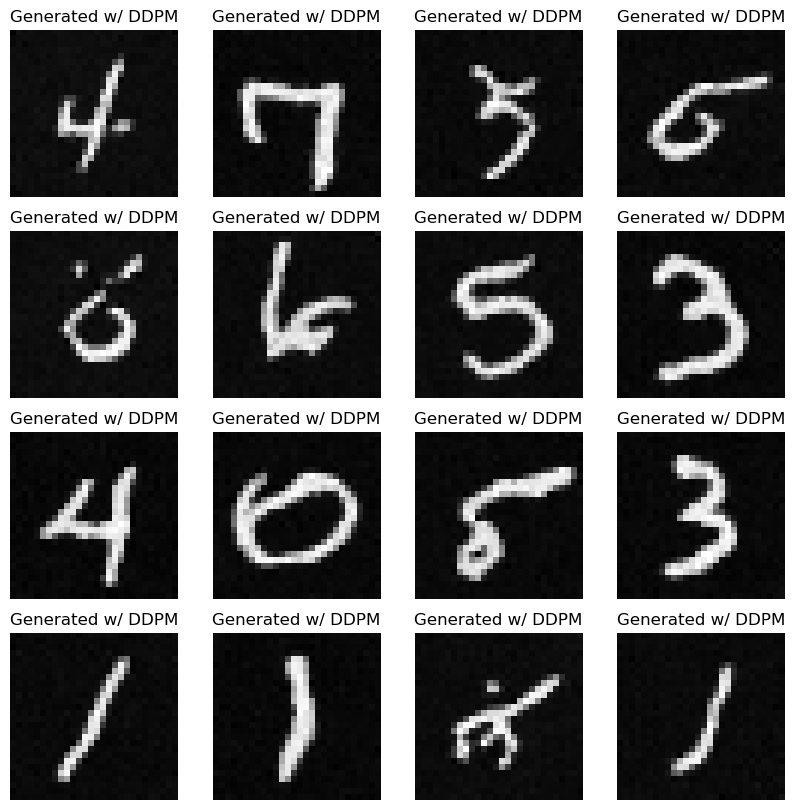

epoch= 6 	 time= 1.5594941655794778 min 	 lr= 0.0003 	 loss= 0.04141808316732446
epoch= 7 	 time= 1.7705656965573628 min 	 lr= 0.0003 	 loss= 0.04088762131209175
epoch= 8 	 time= 1.982250154018402 min 	 lr= 0.0003 	 loss= 0.03992051242850721
epoch= 9 	 time= 2.1933830817540487 min 	 lr= 0.0003 	 loss= 0.039339043109988175
epoch= 10 	 time= 2.404485821723938 min 	 lr= 0.0003 	 loss= 0.038860175817584


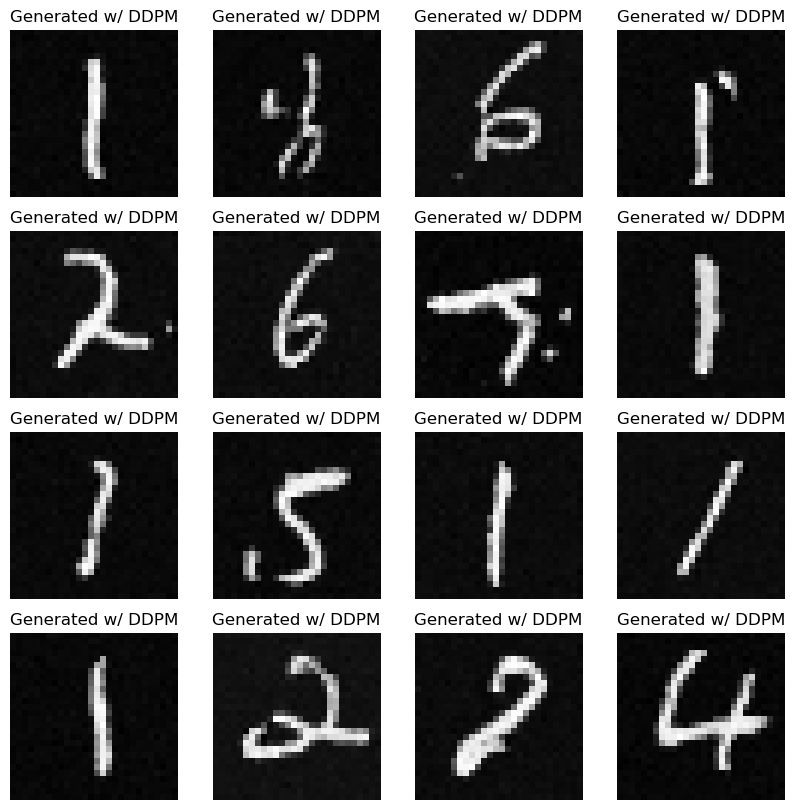

epoch= 11 	 time= 2.637650656700134 min 	 lr= 0.0003 	 loss= 0.03837592249115308
epoch= 12 	 time= 2.849133046468099 min 	 lr= 0.0003 	 loss= 0.03826111411054929
epoch= 13 	 time= 3.060461481412252 min 	 lr= 0.0003 	 loss= 0.037517506387084724
epoch= 14 	 time= 3.271542982260386 min 	 lr= 0.0003 	 loss= 0.03745712916056315
epoch= 15 	 time= 3.4826135198275248 min 	 lr= 0.0003 	 loss= 0.03714554401114583


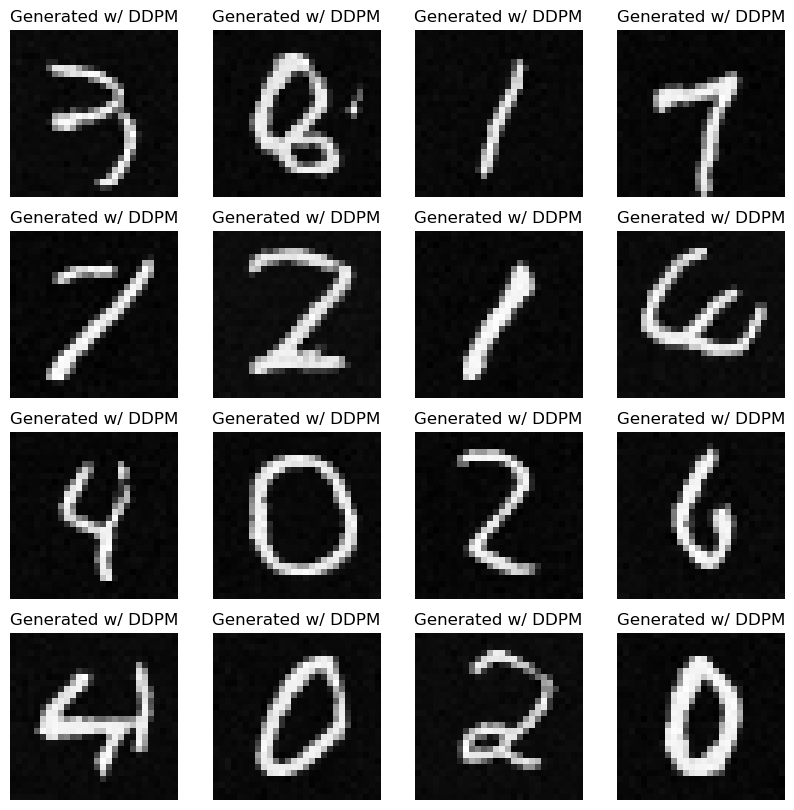

epoch= 16 	 time= 3.7139260093371074 min 	 lr= 0.0003 	 loss= 0.037216175089900695
epoch= 17 	 time= 3.949230420589447 min 	 lr= 0.0003 	 loss= 0.03670682924178739
epoch= 18 	 time= 4.182011620203654 min 	 lr= 0.0003 	 loss= 0.03664756135083735
epoch= 19 	 time= 4.416570301850637 min 	 lr= 0.0003 	 loss= 0.03663612723660966


In [6]:
## Training loop
net = DDPM(num_t, beta_1, beta_T)
net = net.to(device)
display_num_param(net)

# Optimizer
init_lr = 0.0003
optimizer = torch.optim.AdamW(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)

# Number of mini-batches per epoch
nb_epochs = 20

# Training loop
start = time.time()
for epoch in range(nb_epochs):

    running_loss = 0.0
    num_batches = 0

    shuffled_indices = torch.randperm(60000)

    for count in range(0,60000,bs):

        idx_images = shuffled_indices[count : count+bs]
        batch_x0 = train_data[idx_images,:,:].to(device) # [bs, n, n]
        batch_sample_t = torch.randint(0, num_t, (bs,)).long().to(device) # [bs]
        batch_noise_t = torch.randn(batch_x0.size()).to(device) # [bs, n, n]
        x_t = net.forward_process(batch_x0, batch_sample_t, batch_noise_t) # [bs, n, n]
        noise_pred_t = net.backward_process(x_t, batch_sample_t) # [bs, n, n]
        loss_PPDM = torch.nn.MSELoss()(noise_pred_t, batch_noise_t)
        loss = loss_PPDM
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # COMPUTE STATS
        running_loss += loss.detach().item()
        num_batches += 1

    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    scheduler.step(total_loss)
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', optimizer.param_groups[0]['lr']  ,'\t loss=', total_loss )

    # PLOT
    if epoch>0 and not epoch%5:
        net.eval()
        with torch.no_grad():
            num_generated_images = 16
            batch_x_0 = net.generate_process_ppdm(num_generated_images)
            x_hat = batch_x_0.squeeze().detach().to('cpu')
        figure, axis = plt.subplots(4, 4)
        figure.set_size_inches(10,10)
        i,j,cpt=0,0,0; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=1,0,1; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=2,0,2; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=3,0,3; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=0,1+0,4; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=1,1+0,5; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=2,1+0,6; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=3,1+0,7; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=0,2+0,8; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=1,2+0,9; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=2,2+0,10; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=3,2+0,11; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=0,3+0,12; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=1,3+0,13; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=2,3+0,14; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=3,3+0,15; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        plt.show()
        net.train()

    # Check lr value
    if optimizer.param_groups[0]['lr'] < 2*10**-4: 
        print("\n lr is equal to min lr -- training stopped\n")
        break
         

batch_x_0 torch.Size([16, 28, 28])


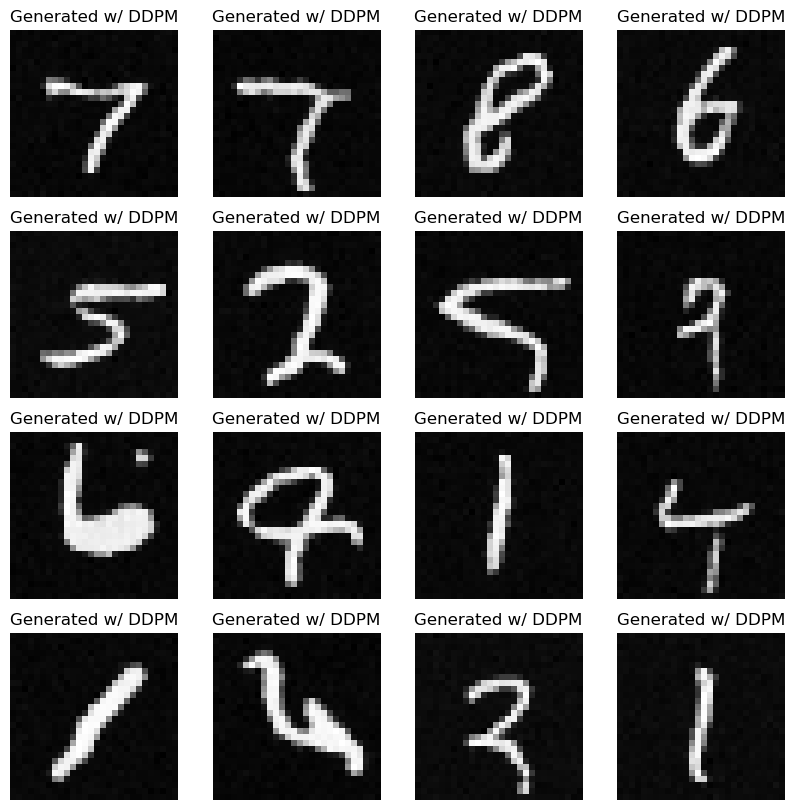

In [13]:
# Generated images with DDPM

net.eval()
with torch.no_grad():
    num_generated_images = 16
    batch_x_0 = net.generate_process_ppdm(num_generated_images)
    print('batch_x_0',batch_x_0.size())
    x_hat = batch_x_0.squeeze().detach().to('cpu')

figure, axis = plt.subplots(4, 4)
figure.set_size_inches(10,10)

i,j,cpt=0,0,0; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=1,0,1; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=2,0,2; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=3,0,3; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=0,1+0,4; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=1,1+0,5; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=2,1+0,6; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=3,1+0,7; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=0,2+0,8; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=1,2+0,9; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=2,2+0,10; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=3,2+0,11; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=0,3+0,12; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=1,3+0,13; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=2,3+0,14; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=3,3+0,15; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')

plt.show()
